<a href="https://colab.research.google.com/github/mariko-sawada/FinRL_with_fundamental_data/blob/main/FinRL_stock_trading_fundamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated stock trading using FinRL with financial data

Trained a Deep Reinforcement Learning model using FinRL and companies' financial ratio, and then backtested the model to examine how well-trained the model is

* This Google Colabolatory notebook is based on the tutorial of FinRL: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530

* This project is a final project of the almuni-mentored research project at Columbia University, Application of Reinforcement Learning to Finance, mentored by Bruce Yang from AI4Finance.
* For more detailed explanation, please check out my Medium post:



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess fundamental Data](#3)        
    * [4-1 Import financial data](#3.1)
    * [4-2 Specify items needed to calculate financial ratios](#3.2)
    * [4-3 Calculate financial ratios](#3.3)
    * [4-4 Deal with NAs and infinite values](#3.4)
    * [4-5 Merge stock price data and ratios into one dataframe](#3.5)
    * [4-6 Calculate market valuation ratios using daily stock price data](#3.6)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-kk5s0iw6
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-kk5s0iw6
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-8p32s0c7/pyfolio_500b53a3d4af4b4289ab43ab7785a6c1
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-8p32s0c7/pyfolio_500b53a3d4af4b4289ab43ab7785a6c1
     |████████████████████████████████| 172 kB 13.2 MB/s 
     |████████████████████████████████| 52 kB 1.9 MB/s 
     |████████████████████████████████| 6.3 MB 41.5 MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-py3-none-any.whl size=62457 sha256=c1a580cf3682c3e4c8cbb8173228eed9e7162190f306c99c10cec017d99addf0
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fudwf6d/wheels/17/ff/bd/1bc602a0352762b0b24041b88536d803ae343ed0a711fcf55e
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Stock Data from Yahoo Finance
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [ ]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [ ]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [ ]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.shape

(90630, 8)

In [ ]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4


# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Compustat via WRDS(Wharton Research Data Service)
- Preprocess the dataset and calculate financial ratios
- Add those ratios to the price data preprocessed in Part 3
- Calculate price-related ratios such as P/E and P/B

## 4-1 Import the financial data

In [ ]:
# Import fundamental data from my GitHub repository
url = 'https://raw.githubusercontent.com/mariko-sawada/FinRL_with_fundamental_data/main/dow_30_fundamental_wrds.csv'

fund = pd.read_csv(url)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Check the imported dataset
fund.head()

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,conm,acctchgq,acctstdq,adrrq,ajexq,ajpq,bsprq,compstq,curcdq,curncdq,currtrq,curuscnq,datacqtr,datafqtr,finalq,ogmq,rp,scfq,srcq,staltq,updq,apdedateq,fdateq,pdateq,rdq,acchgq,acomincq,acoq,actq,altoq,...,uspiy,ustdncy,usubdvpy,utfdocy,utfoscy,utmey,uwkcapcy,wcapchy,wcapcy,wday,wddy,wdepsy,wdpy,xidocy,xidoy,xinty,xiy,xopry,xoptdqpy,xoptdy,xoptepsqpy,xoptepsy,xoptqpy,xopty,xrdy,xsgay,exchg,costat,cshtrq,dvpspq,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,ggroup,gind,gsector,gsubind
0,1447,19990630,1999,2,12,INDL,C,D,STD,AXP,AMERICAN EXPRESS CO,NaN,NaN,NaN,3.0,3.0,GB,NaN,USD,USD,1.0,NaN,1999Q2,1999Q2,Y,NaN,Q,7.0,5,NaN,3,NaN,NaN,NaN,19990726.0,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,9125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,A,106125400.0,0.225,0.225,NaN,130.1250,142.6250,114.5000,3.0,4020,402020,40,40202010
1,1447,19990930,1999,3,12,INDL,C,D,STD,AXP,AMERICAN EXPRESS CO,NaN,NaN,NaN,3.0,3.0,GB,NaN,USD,USD,1.0,NaN,1999Q3,1999Q3,Y,NaN,Q,7.0,5,NaN,3,NaN,NaN,NaN,19991025.0,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,13803.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,A,121724600.0,0.225,0.000,NaN,135.0000,150.6250,121.8750,3.0,4020,402020,40,40202010
2,1447,19991231,1999,4,12,INDL,C,D,STD,AXP,AMERICAN EXPRESS CO,NaN,NaN,NaN,3.0,3.0,GB,NaN,USD,USD,1.0,NaN,1999Q4,1999Q4,Y,NaN,Q,7.0,53,NaN,3,NaN,NaN,NaN,20000124.0,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,18967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,A,126218100.0,0.225,0.225,NaN,166.2500,168.8750,130.2500,3.0,4020,402020,40,40202010
3,1447,20000331,2000,1,12,INDL,C,D,STD,AXP,AMERICAN EXPRESS CO,NaN,NaN,NaN,3.0,3.0,GB,NaN,USD,USD,1.0,NaN,2000Q1,2000Q1,Y,NaN,Q,7.0,5,NaN,3,NaN,NaN,NaN,20000424.0,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,5101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,A,167224700.0,0.225,0.225,NaN,148.9375,169.5000,119.5000,3.0,4020,402020,40,40202010
4,1447,20000630,2000,2,12,INDL,C,D,STD,AXP,AMERICAN EXPRESS CO,NaN,NaN,NaN,1.0,1.0,GB,NaN,USD,USD,1.0,NaN,2000Q2,2000Q2,Y,NaN,Q,7.0,5,NaN,3,NaN,NaN,NaN,20000724.0,0.0,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,10425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,A,325319600.0,0.080,0.080,NaN,52.1250,57.1875,43.9375,1.0,4020,402020,40,40202010


## 4-2 Specify items needed to calculate financial ratios
- To know more about the data description of the dataset, please check WRDS's website(https://wrds-www.wharton.upenn.edu/). Login will be required.

In [ ]:
# List items that are used to calculate financial ratios

items = [
    'datadate', # Date
    'tic', # Ticker
    'oiadpq', # Quarterly operating income
    'revtq', # Quartely revenue
    'niq', # Quartely net income
    'atq', # Total asset
    'teqq', # Shareholder's equity
    'epspiy', # EPS(Basic) incl. Extraordinary items
    'ceqq', # Common Equity
    'cshoq', # Common Shares Outstanding
    'dvpspq', # Dividends per share
    'actq', # Current assets
    'lctq', # Current liabilities
    'cheq', # Cash & Equivalent
    'rectq', # Recievalbles
    'cogsq', # Cost of  Goods Sold
    'invtq', # Inventories
    'apq',# Account payable
    'dlttq', # Long term debt
    'dlcq', # Debt in current liabilites
    'ltq' # Liabilities   
]

# Omit items that will not be used
fund_data = fund[items]

In [ ]:
# Rename column names for the sake of readability
fund_data = fund_data.rename(columns={
    'datadate':'date', # Date
    'oiadpq':'op_inc_q', # Quarterly operating income
    'revtq':'rev_q', # Quartely revenue
    'niq':'net_inc_q', # Quartely net income
    'atq':'tot_assets', # Assets
    'teqq':'sh_equity', # Shareholder's equity
    'epspiy':'eps_incl_ex', # EPS(Basic) incl. Extraordinary items
    'ceqq':'com_eq', # Common Equity
    'cshoq':'sh_outstanding', # Common Shares Outstanding
    'dvpspq':'div_per_sh', # Dividends per share
    'actq':'cur_assets', # Current assets
    'lctq':'cur_liabilities', # Current liabilities
    'cheq':'cash_eq', # Cash & Equivalent
    'rectq':'receivables', # Receivalbles
    'cogsq':'cogs_q', # Cost of  Goods Sold
    'invtq':'inventories', # Inventories
    'apq': 'payables',# Account payable
    'dlttq':'long_debt', # Long term debt
    'dlcq':'short_debt', # Debt in current liabilites
    'ltq':'tot_liabilities' # Liabilities   
})

In [ ]:
# Check the data
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,div_per_sh,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,19990630,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,0.225,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,19990930,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,0.225,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,19991231,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,0.225,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,20000331,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,0.225,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,20000630,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,0.080,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


## 4-3 Calculate financial ratios
- For items from Profit/Loss statements, we calculate LTM (Last Twelve Months) and use them to derive profitability related ratios such as Operating Maring and ROE. For items from balance sheets, we use the numbers on the day.
- To check the definitions of the financial ratios calculated here, please refer to CFI's website: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

In [ ]:
# Calculate financial ratios
date = pd.to_datetime(fund_data['date'],format='%Y%m%d')

tic = fund_data['tic'].to_frame('tic')

# Profitability ratios
# Operating Margin
OPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='OPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        OPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        OPM.iloc[i] = np.nan
    else:
        OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Net Profit Margin        
NPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='NPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        NPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        NPM.iloc[i] = np.nan
    else:
        NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Return On Assets
ROA = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROA')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROA[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROA.iloc[i] = np.nan
    else:
        ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['tot_assets'].iloc[i]

# Return on Equity
ROE = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROE')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROE[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROE.iloc[i] = np.nan
    else:
        ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['sh_equity'].iloc[i]        

# For calculating valuation ratios in the next subpart, calculate per share items in advance
# Earnings Per Share       
EPS = fund_data['eps_incl_ex'].to_frame('EPS')

# Book Per Share
BPS = (fund_data['com_eq']/fund_data['sh_outstanding']).to_frame('BPS') # Need to check units

#Dividend Per Share
DPS = fund_data['div_per_sh'].to_frame('DPS')

# Liquidity ratios
# Current ratio
cur_ratio = (fund_data['cur_assets']/fund_data['cur_liabilities']).to_frame('cur_ratio')

# Quick ratio
quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables'] )/fund_data['cur_liabilities']).to_frame('quick_ratio')

# Cash ratio
cash_ratio = (fund_data['cash_eq']/fund_data['cur_liabilities']).to_frame('cash_ratio')


# Efficiency ratios
# Inventory turnover ratio
inv_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='inv_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        inv_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        inv_turnover.iloc[i] = np.nan
    else:
        inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['inventories'].iloc[i]

# Receivables turnover ratio       
acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_rec_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_rec_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_rec_turnover.iloc[i] = np.nan
    else:
        acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i])/fund_data['receivables'].iloc[i]

# Payable turnover ratio
acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_pay_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_pay_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_pay_turnover.iloc[i] = np.nan
    else:
        acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['payables'].iloc[i]
        
## Leverage financial ratios
# Debt ratio
debt_ratio = (fund_data['tot_liabilities']/fund_data['tot_assets']).to_frame('debt_ratio')

# Debt to Equity ratio
debt_to_equity = (fund_data['tot_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# Create a dataframe that merges all the ratios
ratios = pd.concat([date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,
                    cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,
                   debt_ratio,debt_to_equity], axis=1)

In [ ]:
# Check the ratio data
ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,NaN,NaN,NaN,NaN,2.73,21.741648,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926298,12.568121
1,1999-09-30,AXP,NaN,NaN,NaN,NaN,4.18,21.769437,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926525,12.610016
2,1999-12-31,AXP,NaN,NaN,NaN,NaN,5.54,22.588946,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,NaN,NaN,NaN,46.0635,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.0128574,0.181749,1.05,7.883721,0.080,NaN,NaN,NaN,57.2529,0.324467,0.505925,0.929258,13.135788


In [ ]:
ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,inf,6.11635,2.69754,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,inf,5.06313,1.88951,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.52129,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,inf,5.62857,2.73037,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.0944222,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,inf,4.72531,2.34787,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.0952179,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,inf,4.84496,2.36736,0.529946,1.127414


## 4-4 Deal with NAs and infinite values
- We replace N/A and infinite values with zero so that they can be recognized as a state

In [ ]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf,0)

In [ ]:
final_ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,0.000000,0.000000,0.000000,0.000000,2.73,21.741648,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926298,12.568121
1,1999-09-30,AXP,0.000000,0.000000,0.000000,0.000000,4.18,21.769437,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926525,12.610016
2,1999-12-31,AXP,0.000000,0.000000,0.000000,0.000000,5.54,22.588946,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,0.0,0.0,0.0,46.063492,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.012857,0.181749,1.05,7.883721,0.080,0.0,0.0,0.0,57.252874,0.324467,0.505925,0.929258,13.135788


In [ ]:
final_ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,0.0,6.116350,2.697537,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,0.0,5.063131,1.889507,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.521290,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,0.0,5.628571,2.730366,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.094422,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,0.0,4.725314,2.347866,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.095218,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,0.0,4.844961,2.367357,0.529946,1.127414


## 4-5 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [ ]:
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
combination = list(itertools.product(list_date,list_ticker))

# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
processed_full = processed_full.merge(final_ratios,how='left',on=['date','tic'])
processed_full = processed_full.sort_values(['tic','date'])

# Backfill the ratio data to make them daily
processed_full = processed_full.bfill(axis='rows')


## 4-6 Calculate market valuation ratios using daily stock price data 

In [ ]:
# Calculate P/E, P/B and dividend yield using daily closing price
processed_full['PE'] = processed_full['close']/processed_full['EPS']
processed_full['PB'] = processed_full['close']/processed_full['BPS']
processed_full['Div_yield'] = processed_full['DPS']/processed_full['close']

# Drop per share items used for the above calculation
processed_full = processed_full.drop(columns=['day','EPS','BPS','DPS'])

In [ ]:
# Check the final data
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,ROE,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.782837,746015200.0,0.217886,0.163846,0.103222,0.183579,2.461857,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.639733,0.102096,0.000000
1,2009-01-02,AXP,18.570000,19.520000,18.400000,15.657365,10955700.0,0.093973,0.072040,0.014094,0.108238,0.000000,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,50.507629,1.450032,0.011496
2,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,0.047307,0.032525,0.026400,-2.870334,0.927883,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,39.012760,-35.751054,0.012374
3,2009-01-02,CAT,44.910000,46.980000,44.709999,32.655109,7117200.0,0.124545,0.066662,0.040891,0.415878,1.343293,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-171.868997,3.151894,0.012862
4,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.505757,40980600.0,0.234698,0.196418,0.097593,0.162793,2.792929,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,19.850408,1.986886,0.000000
5,2009-01-02,CVX,74.230003,77.300003,73.580002,46.800758,13695900.0,0.141417,0.097223,0.117691,0.213663,1.368819,0.952878,0.373760,23.920348,13.387209,11.276861,0.449174,0.815455,50.870390,1.074527,0.013889
6,2009-01-02,DD,21.605234,22.060680,20.993229,15.219840,13251037.0,0.167221,0.102157,0.045834,0.084230,1.175830,0.815629,0.330748,11.310223,5.725855,4.287167,0.455848,0.837721,19.265620,0.832398,0.022996
7,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597496,9796600.0,0.167221,0.102157,0.045834,0.084230,1.175830,0.815629,0.330748,11.310223,5.725855,4.287167,0.455848,0.837721,26.072780,1.126511,0.016992
8,2009-01-02,GS,84.019997,87.620003,82.190002,72.315208,14088500.0,0.608183,0.023205,0.000876,0.012761,0.000000,0.000000,0.000000,0.036288,0.116995,0.044756,0.930155,13.542445,20.780232,0.731821,0.006454
9,2009-01-02,HD,23.070000,24.190001,22.959999,17.705078,14902500.0,0.082162,0.040825,0.056214,0.000000,1.198063,0.134224,0.047073,3.526750,58.313786,7.806097,0.568142,0.000000,13.212745,1.689138,0.012708


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## 5-1 Split data into training and trade dataset
- Training data split: 2009-01-01 to 2018-12-31
- Trade data split: 2019-01-01 to 2020-09-30

In [ ]:
train = data_split(processed_full, '2009-01-01','2019-01-01')
trade = data_split(processed_full, '2019-01-01','2021-01-01')
# Check the length of the two datasets
print(len(train))
print(len(trade))

109530
21930


In [ ]:
train.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,ROE,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.782837,746015200.0,0.217886,0.163846,0.103222,0.183579,2.461857,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.639733,0.102096,0.000000
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.657365,10955700.0,0.093973,0.072040,0.014094,0.108238,0.000000,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,50.507629,1.450032,0.011496
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,0.047307,0.032525,0.026400,-2.870334,0.927883,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,39.012760,-35.751054,0.012374
0,2009-01-02,CAT,44.910000,46.980000,44.709999,32.655109,7117200.0,0.124545,0.066662,0.040891,0.415878,1.343293,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-171.868997,3.151894,0.012862
0,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.505757,40980600.0,0.234698,0.196418,0.097593,0.162793,2.792929,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,19.850408,1.986886,0.000000


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,ROE,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,38.382229,148158800.0,0.258891,0.227773,0.133360,0.430843,1.315382,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.728691,1.670488,0.019019
0,2019-01-01,AXP,93.910004,96.269997,93.769997,91.803406,4175400.0,0.203479,0.160494,0.026811,0.237960,0.000000,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,50.720114,3.458432,0.004248
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,0.116496,0.102682,0.066409,34.409483,1.070490,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.019826,1418.196271,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,117.506577,4783200.0,0.186871,0.107064,0.056932,0.289572,1.428582,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,35.716285,4.351801,0.007319
0,2019-01-01,CSCO,42.279999,43.200001,42.209999,39.496738,23833500.0,0.263373,0.261680,0.098017,0.246218,1.801859,1.677431,1.370671,7.722516,4.244056,7.937160,0.601911,1.512001,28.011871,4.283841,0.008355


## 5-2 Set up the training environment

In [ ]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 511


In [ ]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=100000)

Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 60       |
|    iterations         | 100      |
|    time_elapsed       | 8        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0.157    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 165      |
|    std                | 1.01     |
|    value_loss         | 18.3     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 68       |
|    iterations         | 200      |
|    time_elapsed       | 14       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0.0513   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 66       |
|    time_elapsed    | 221      |
|    total timesteps | 14604    |
| train/             |          |
|    actor_loss      | 14.4     |
|    critic_loss     | 878      |
|    learning_rate   | 0.001    |
|    n_updates       | 10953    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 62       |
|    time_elapsed    | 465      |
|    total timesteps | 29208    |
| train/             |          |
|    actor_loss      | -7.77    |
|    critic_loss     | 3.91     |
|    learning_rate   | 0.001    |
|    n_updates       | 25557    |
---------------------------------
day: 3650, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3722031.15
total_reward: 2722031.15
total_cost: 999.00
total_trades: 65700


### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

Logging to tensorboard_log/ppo/ppo_1
-----------------------------
| time/              |      |
|    fps             | 76   |
|    iterations      | 1    |
|    time_elapsed    | 26   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 2           |
|    time_elapsed         | 54          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018077655 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0123     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.1         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0292     |
|    std                  | 1           |
|    value_loss           | 7.21       

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 26       |
|    time_elapsed    | 559      |
|    total timesteps | 14604    |
| train/             |          |
|    actor_loss      | 4.64     |
|    critic_loss     | 720      |
|    learning_rate   | 0.001    |
|    n_updates       | 10953    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 22       |
|    time_elapsed    | 1289     |
|    total timesteps | 29208    |
| train/             |          |
|    actor_loss      | 10.6     |
|    critic_loss     | 14.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 25557    |
---------------------------------
day: 3650, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 3319811.55
total_reward: 2319811.55
total_cost: 998.99
total_trades: 51100
Sh

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=80000)

Logging to tensorboard_log/sac/sac_2
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 21       |
|    time_elapsed    | 685      |
|    total timesteps | 14604    |
| train/             |          |
|    actor_loss      | 172      |
|    critic_loss     | 28.6     |
|    ent_coef        | 0.0742   |
|    ent_coef_loss   | -126     |
|    learning_rate   | 0.0001   |
|    n_updates       | 14503    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 20       |
|    time_elapsed    | 1401     |
|    total timesteps | 29208    |
| train/             |          |
|    actor_loss      | 9.68     |
|    critic_loss     | 9.81     |
|    ent_coef        | 0.0174   |
|    ent_coef_loss   | -173     |
|    learning_rate   | 0.0001   |
|    n_updates       | 29107    |
---------------------------------
day: 3650, 

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
trade = data_split(processed_full, '2019-01-01','2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,ROE,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,38.382229,148158800.0,0.258891,0.227773,0.133360,0.430843,1.315382,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.728691,1.670488,0.019019
0,2019-01-01,AXP,93.910004,96.269997,93.769997,91.803406,4175400.0,0.203479,0.160494,0.026811,0.237960,0.000000,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,50.720114,3.458432,0.004248
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,0.116496,0.102682,0.066409,34.409483,1.070490,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.019826,1418.196271,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,117.506577,4783200.0,0.186871,0.107064,0.056932,0.289572,1.428582,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,35.716285,4.351801,0.007319
0,2019-01-01,CSCO,42.279999,43.200001,42.209999,39.496738,23833500.0,0.263373,0.261680,0.098017,0.246218,1.801859,1.677431,1.370671,7.722516,4.244056,7.937160,0.601911,1.512001,28.011871,4.283841,0.008355


In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.shape

(731, 2)

In [ ]:
df_account_value.tail()

,date,account_value
726,2020-12-27,1.366946e+06
727,2020-12-28,1.366946e+06
728,2020-12-29,1.362735e+06
729,2020-12-30,1.366732e+06
730,2020-12-31,1.376233e+06


In [ ]:
df_actions.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0,100,0,100,100,100,100,100,0,100,0,0,0,100,0,100,0,100,100,0,100,0,0,100,100,100,0,100,100,100
2019-01-02,0,100,0,100,100,100,100,100,0,100,0,0,0,100,0,100,0,100,100,0,100,0,0,100,100,100,0,100,100,100
2019-01-03,0,100,0,100,100,100,100,100,0,100,0,0,0,100,0,100,0,100,100,0,100,0,0,100,100,100,0,100,100,100
2019-01-04,0,100,0,100,100,100,100,100,0,100,0,0,0,100,0,100,0,100,100,0,100,0,0,100,100,100,0,100,100,100
2019-01-05,0,100,0,100,100,100,100,100,0,100,0,0,0,100,0,100,0,100,100,0,100,0,0,100,100,100,0,100,100,100


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.116379
Cumulative returns     0.376233
Annual volatility      0.226615
Sharpe ratio           0.600746
Calmar ratio           0.339548
Stability              0.318862
Max drawdown          -0.342748
Omega ratio            1.173419
Sortino ratio          0.834111
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.921395
Daily value at risk   -0.028011
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = '2019-01-01',
        end = '2021-01-01')

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,20.173%
Cumulative returns,44.521%
Annual volatility,22.414%
Sharpe ratio,0.93
Calmar ratio,0.99
Stability,0.86
Max drawdown,-20.384%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.38,2020-02-19,2020-03-12,2020-03-26,27
1,10.32,2020-06-08,2020-07-09,2020-11-13,115
2,9.64,2020-03-26,2020-04-01,2020-04-29,25
3,5.38,2020-04-29,2020-05-13,2020-06-03,26
4,4.77,2019-09-18,2019-10-02,2019-11-07,37


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


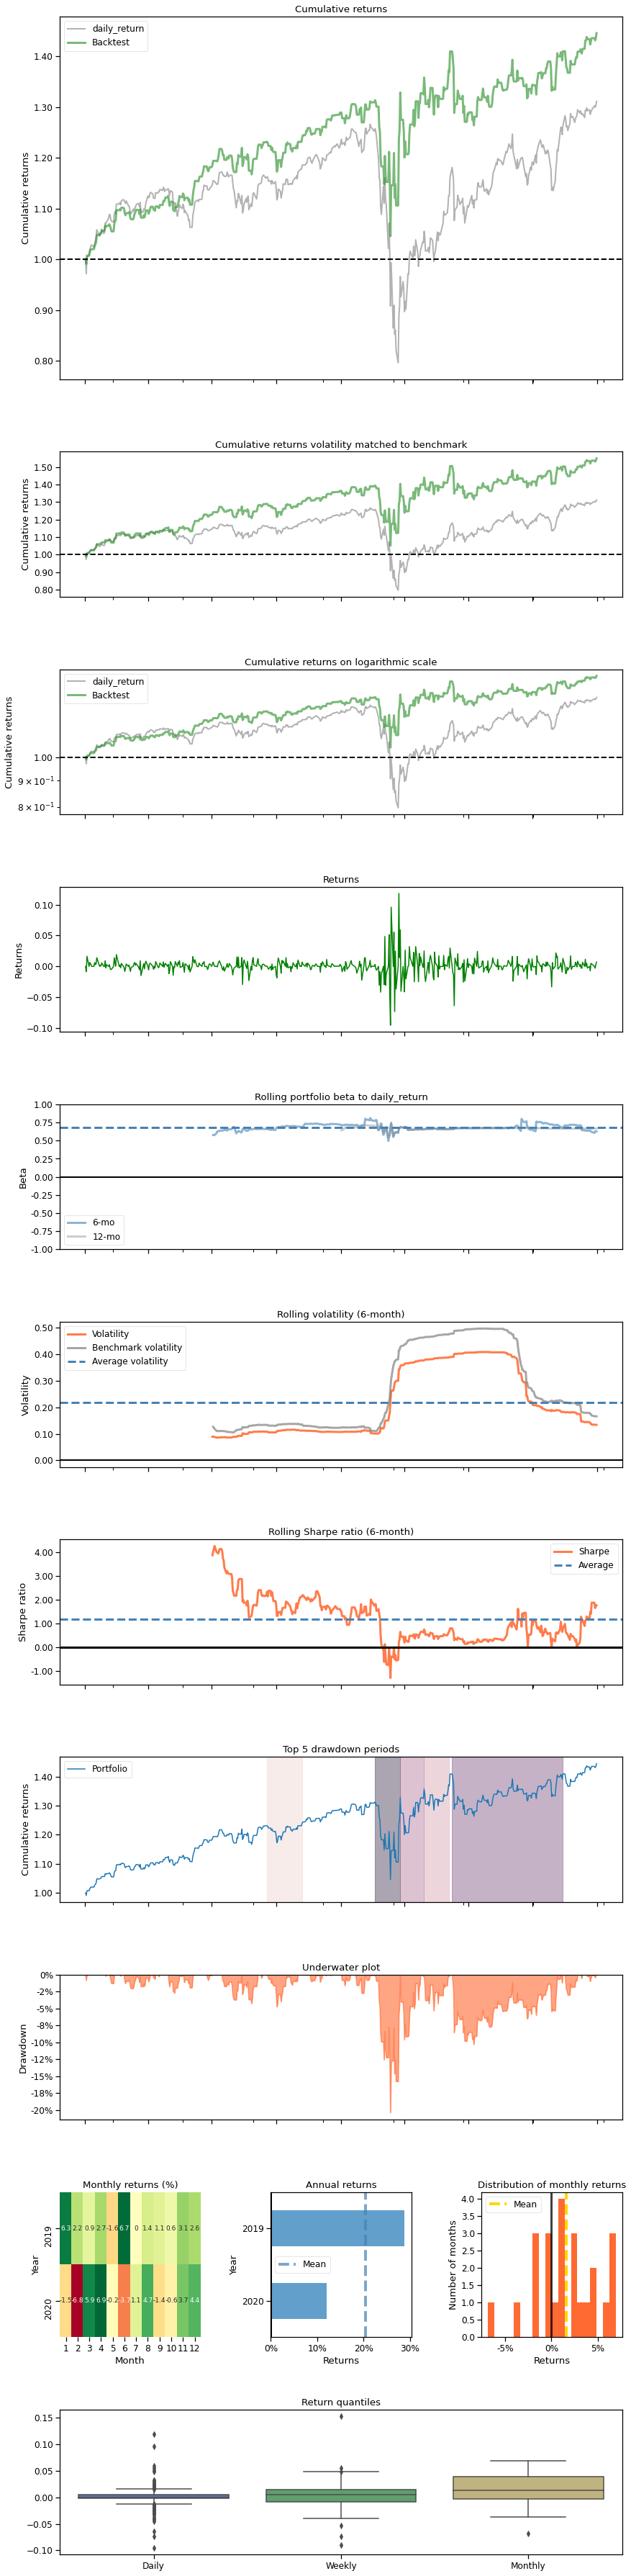

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')